In [2]:
%matplotlib inline
from __future__ import print_function, unicode_literals
import sys, os
import seaborn as sns
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

In [1]:
from pygaarst import raster

In [3]:
sys.path.append('../firedetection/')
import landsat8fire as lfire

In [4]:
sns.set(rc={'image.cmap': 'gist_heat'})
sns.set(rc={'image.cmap': 'bone'})

sns.set_context("poster")

myfontsize = 20
font = {'family' : 'Calibri',
        'weight': 'bold',
        'size'   : myfontsize}
matplotlib.rc('font', **font)
matplotlib.axes.rcParams['axes.labelsize']=myfontsize-4
matplotlib.axes.rcParams['axes.titlesize']=myfontsize
cmap1 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'red']))
cmap2 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'neon green']))
cmap3 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'orange']))

In [6]:
landsatpath = '/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/Landsat/L8 OLI_TIRS Sockeye'
lsscene = 'LC80700172015166LGN00'
landsat = raster.Landsatscene(os.path.join(landsatpath, lsscene))

In [20]:
landsat.infix = '_clip'
rho7 = landsat.band7.reflectance
rho6 = landsat.band6.reflectance
rho5 = landsat.band5.reflectance
rho4 = landsat.band4.reflectance
rho3 = landsat.band3.reflectance
rho2 = landsat.band2.reflectance
rho1 = landsat.band1.reflectance
R75 = rho7/rho5
R76 = rho7/rho6

In [8]:
xmax = landsat.band7.ncol
ymax = landsat.band7.nrow

"Unambiguous fire pixels" test 1 (daytime, normal conditions).

In [9]:
firecond1 = np.logical_and(R75 > 2.5, rho7 > .5)
firecond1 = np.logical_and(firecond1, rho7 - rho5 > .3)
firecond1_masked = np.ma.masked_where(
        ~firecond1, np.ones((ymax, xmax)))

"Unambiguous fire pixels" test 2 (daytime, sensor anomalies)

In [10]:
firecond2 = np.logical_and(rho6 > .8, rho1 < .2)
firecond2 = np.logical_and(firecond2, 
    np.logical_or(rho5 > .4, rho7 < .1)
    )
firecond2_masked = np.ma.masked_where(
        ~firecond2, np.ones((ymax, xmax)))

"Relaxed conditions"

In [11]:
firecond3 = np.logical_and(R75 > 1.8, rho7 - rho5 > .17)
firecond3_masked = np.ma.masked_where(
        ~firecond3, np.ones((ymax, xmax)))

"Extra tests" for relaxed conditions:

1. R76 > 1.6
2. R75 at least 3 sigma and 0.8 larger than avg of a 61x61 window of valid pixels
3. rho7 at least 3 sigma and 0.08 larger than avg of a 61x61 window of valid pixels

Valid pixels are:

1. Not "unambiguous fire pixel"
2. rho7 > 0 
3. Not water as per water test 1: rho4 > rho5 AND rho5 > rho6 AND rho6 > rho7 AND rho1 - rho7 < 0.2
4. Not water as per test 2: rho3 > rho2 OR ( rho1 > rho2 AND rho2 > rho3 AND rho3 > rho4 )


So let's get started on the validation tests...

In [12]:
newfirecandidates = np.logical_and(~firecond1, ~firecond2)
newfirecandidates = np.logical_and(newfirecandidates, firecond3)
newfirecandidates = np.logical_and(newfirecandidates, R76 > 0)
sum(sum(newfirecandidates))

95

We'll need a +-30 pixel window around a coordinate pair to carry out the averaging for the contextual tests

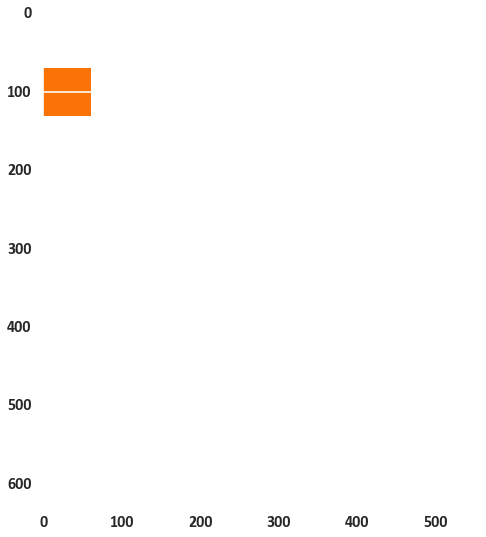

In [16]:
iidxmax, jidxmax = landsat.band1.data.shape 

def get_window(ii, jj, N, iidxmax, jidxmax):
    """Return 2D Boolean array that is True where a window of size N
    around a given point is masked out """
    imin = max(0, ii-N)
    imax = min(iidxmax, ii+N)
    jmin = max(0, jj-N)
    jmax = min(jidxmax, jj+N)
    mask1 = np.zeros((iidxmax, jidxmax))
    mask1[imin:imax+1, jmin:jmax+1] = 1
    return mask1 == 1
    
plt.imshow(get_window(100, 30, 30, iidxmax, jidxmax) , cmap=cmap3, vmin=0, vmax=1)

We can then get the union of those windows over all detected fire pixel candidates. 

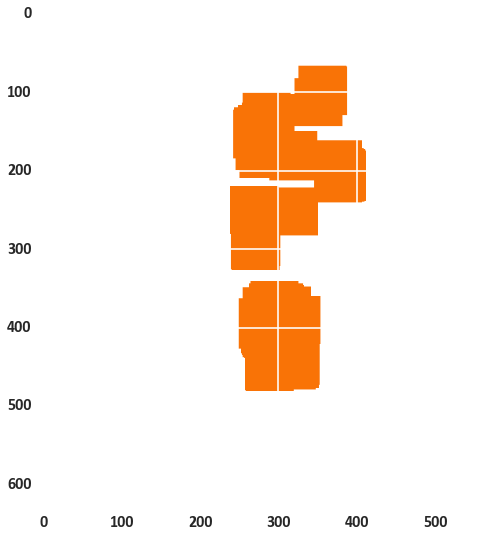

In [17]:
windows = [get_window(ii, jj, 30, iidxmax, jidxmax) for ii, jj in np.argwhere(newfirecandidates)]
window = np.any(windows, axis=0)
plt.imshow(window , cmap=cmap3, vmin=0, vmax=1)

We also need a water mask... 

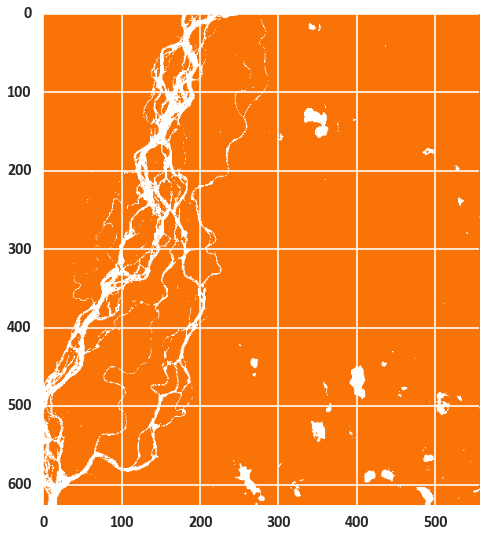

In [23]:
def get_l8watermask_frombands(
        rho1, rho2, rho3,
        rho4, rho5, rho6, rho7):
    """
    Takes L8 bands, returns 2D Boolean numpy array of same shape
    """
    turbidwater = get_l8turbidwater(rho1, rho2, rho3, rho4, rho5, rho6, rho7)
    deepwater = get_l8deepwater(rho1, rho2, rho3, rho4, rho5, rho6, rho7)
    return np.logical_or(turbidwater, deepwater)

def get_l8commonwater(rho1, rho4, rho5, rho6, rho7):
    """Returns Boolean numpy array common to turbid and deep water schemes"""
    water1cond = np.logical_and(rho4 > rho5, rho5 > rho6)
    water1cond = np.logical_and(water1cond, rho6 > rho7)
    water1cond = np.logical_and(water1cond, rho1 - rho7 < 0.2)
    return water1cond

def get_l8turbidwater(rho1, rho2, rho3, rho4, rho5, rho6, rho7):
    """Returns Boolean numpy array that marks shallow, turbid water"""
    watercond2 = get_l8commonwater(rho1, rho4, rho5, rho6, rho7)
    watercond2 = np.logical_and(watercond2, rho3 > rho2)
    return watercond2

def get_l8deepwater(rho1, rho2, rho3, rho4, rho5, rho6, rho7):
    """Returns Boolean numpy array that marks deep, clear water"""
    watercond3 = get_l8commonwater(rho1, rho4, rho5, rho6, rho7)
    watercondextra = np.logical_and(rho1 > rho2, rho2 > rho3)
    watercondextra = np.logical_and(watercondextra, rho3 > rho4)
    return np.logical_and(watercond3, watercondextra)

water = get_l8watermask_frombands(rho1, rho2, rho3, rho4, rho5, rho6, rho7)
plt.imshow(~water , cmap=cmap3, vmin=0, vmax=1)

Let's try out the two components, out of interest... apparently, only the "deep water" test catches the water bodies here. 

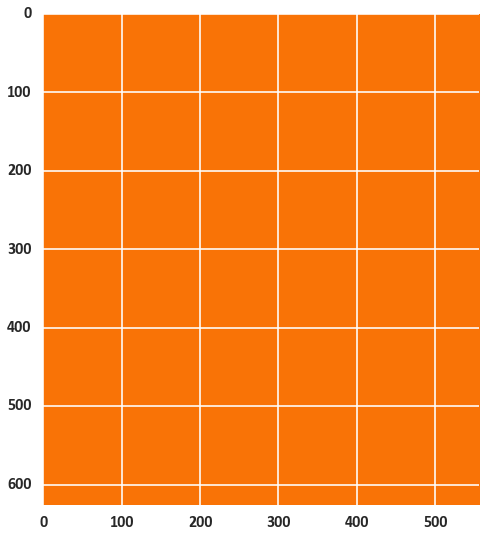

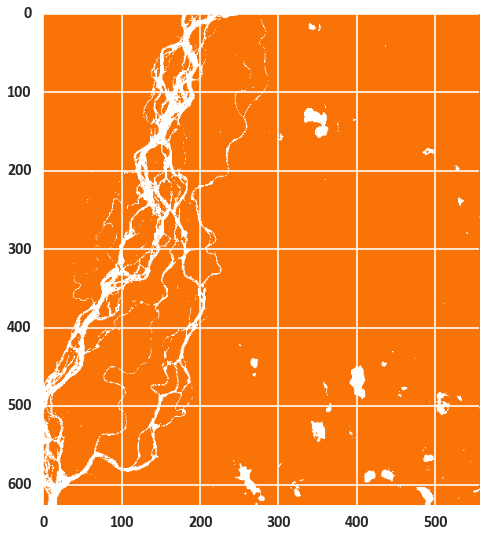

In [24]:
turbidwater = get_l8turbidwater(rho1, rho2, rho3, rho4, rho5, rho6, rho7)
deepwater = get_l8deepwater(rho1, rho2, rho3, rho4, rho5, rho6, rho7)
plt.imshow(~turbidwater , cmap=cmap3, vmin=0, vmax=1)
plt.show()
plt.imshow(~deepwater , cmap=cmap3, vmin=0, vmax=1)

In [28]:
def get_valid_pixels(otherfirecond, rho1, rho2, rho3,
                     rho4, rho5, rho6, rho7, mask=None):
    """returns masked array of 1 for valid, 0 for not"""
    if not np.any(mask):
        mask = np.zeros(otherfirecond.shape)
    rho = {}
    for rho in [rho1, rho2, rho3, rho4, rho5, rho6, rho7]:
        rho = np.ma.masked_array(rho, mask=mask)
    watercond = get_l8watermask_frombands(
        rho1, rho2, rho3,
        rho4, rho5, rho6, rho7)
    greater0cond = rho7 > 0
    finalcond = np.logical_and(greater0cond, ~watercond)
    finalcond = np.logical_and(finalcond, ~otherfirecond)
    return np.ma.masked_array(finalcond, mask=mask)

otherfirecond = np.logical_or(firecond1, firecond2)
validpix = get_valid_pixels(otherfirecond, rho1, rho2, rho3,
                     rho4, rho5, rho6, rho7, mask=~window)

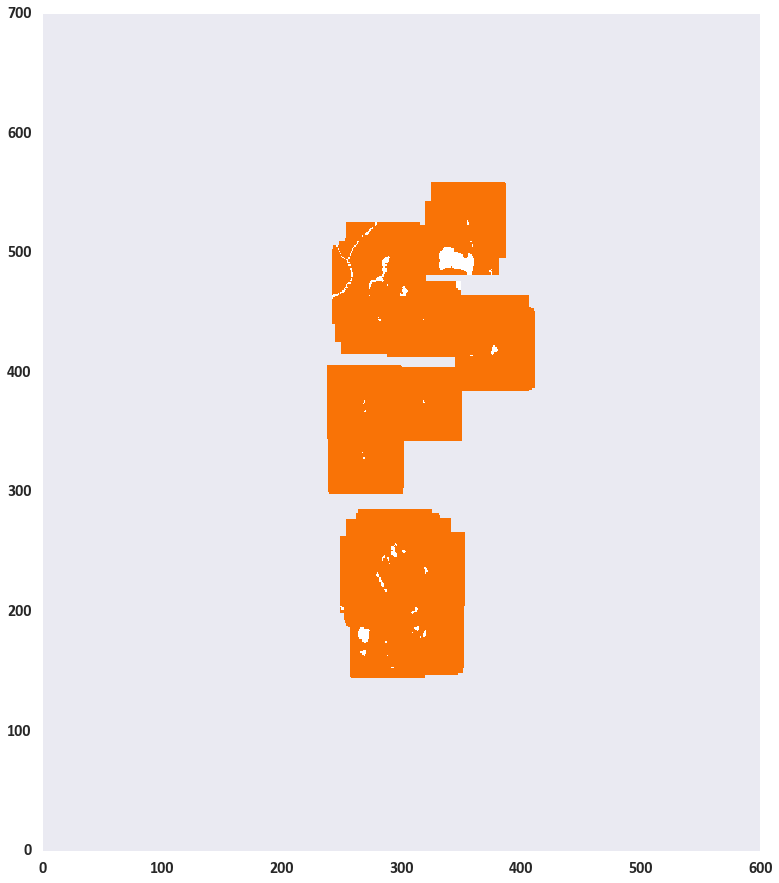

In [29]:
fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.set_aspect('equal')

ax1.pcolormesh(np.flipud(validpix), cmap=cmap3, vmin=0, vmax=1)

In [30]:
iidxmax, jidxmax = landsat.band1.data.shape 
output = np.zeros((iidxmax, jidxmax))

for ii, jj in np.argwhere(firecond3):
    window = get_window(ii, jj, 30, iidxmax, jidxmax)
    newmask = np.logical_or(~window, ~validpix.data)
    rho7_win = np.ma.masked_array(rho7, mask=newmask)
    R75_win = np.ma.masked_array(rho7/rho5, mask=newmask)
    rho7_bar = np.mean(rho7_win.flatten())
    rho7_std = np.std(rho7_win.flatten())
    R75_bar = np.mean(R75_win.flatten())
    R75_std = np.std(R75_win.flatten())
    rho7_test = rho7_win[ii, jj] - rho7_bar > max(3*rho7_std, 0.08)
    R75_test = R75_win[ii, jj]- R75_bar > max(3*R75_std, 0.8)
    if rho7_test and R75_test:
        output[ii, jj] = 1

lowfirecond = output == 1

In [31]:
sum(sum(lowfirecond))

95

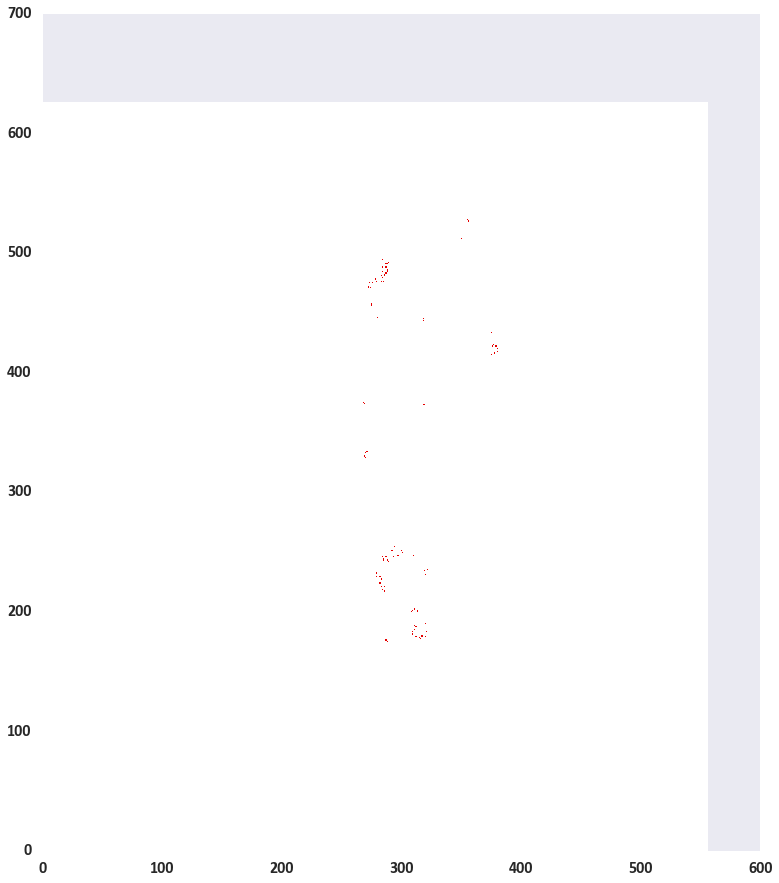

In [34]:
fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.set_aspect('equal')

ax1.pcolormesh(np.flipud(lowfirecond), cmap=cmap1, vmin=0, vmax=1)

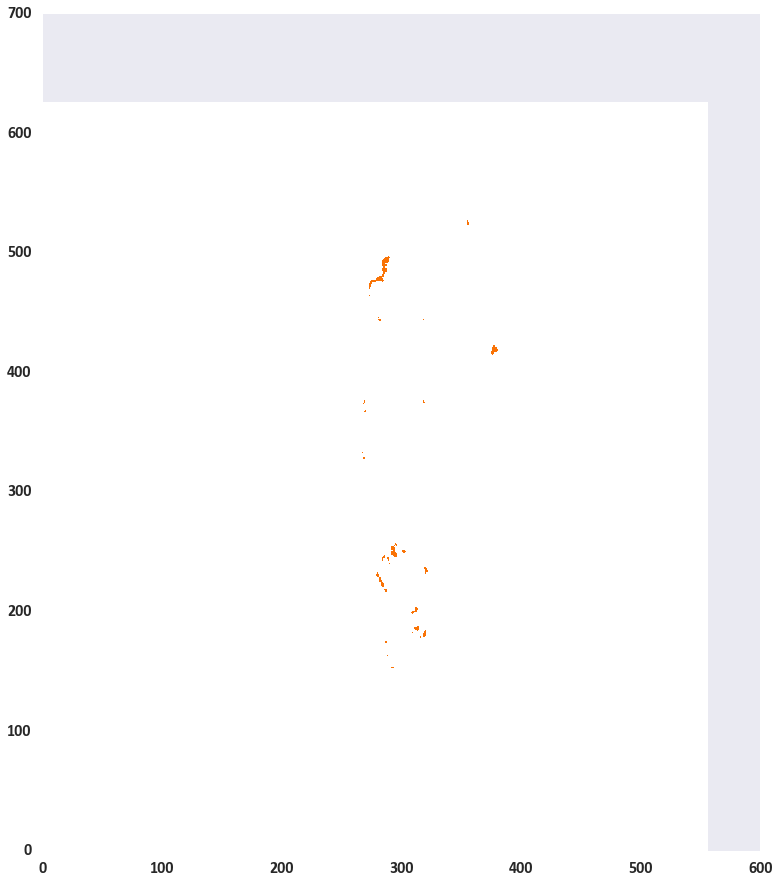

In [33]:
fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.set_aspect('equal')

ax1.pcolormesh(np.flipud(firecond1), cmap=cmap3, vmin=0, vmax=1)

In [35]:
allfirecond = np.logical_or(firecond1, firecond2)
allfirecond = np.logical_or(allfirecond, lowfirecond)

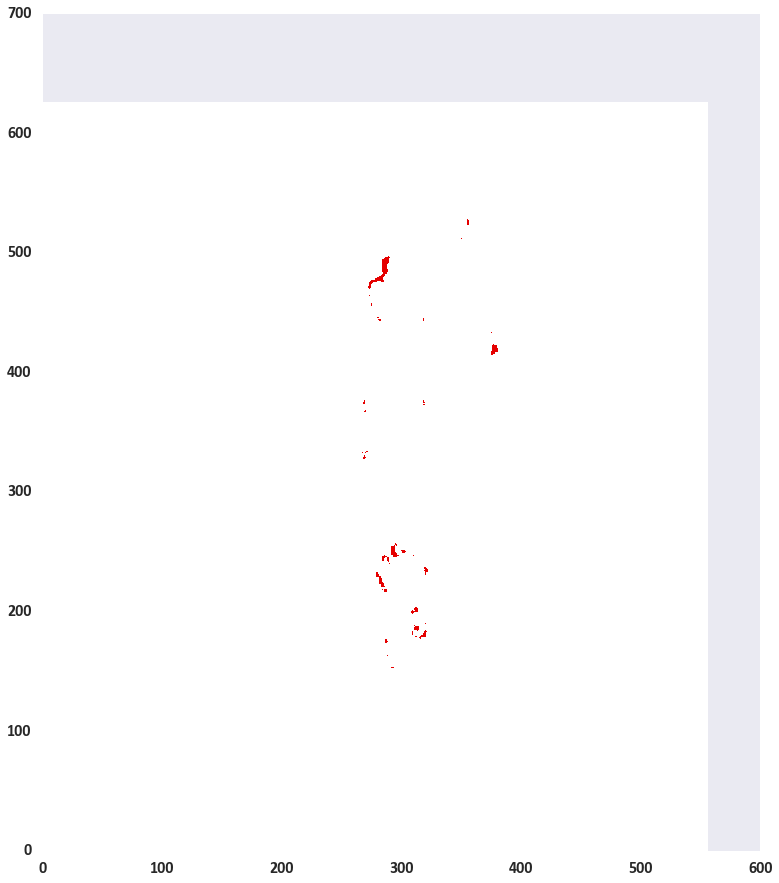

In [39]:
fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.set_aspect('equal')
ax1.pcolormesh(np.flipud(allfirecond), cmap=cmap1, vmin=0, vmax=1)

So this works! Now we can do the same using the module that incorporates the above code:

In [40]:
testfire, highfire, anomfire, lowfire = lfire.get_l8fire(landsat)

In [41]:
sum(sum(lowfire))

95

In [46]:
sum(sum(testfire))

390

In [47]:
firecond1_masked = np.ma.masked_where(
        ~testfire, np.ones((ymax, xmax)))
firecondlow_masked = np.ma.masked_where(
        ~lowfire, np.ones((ymax, xmax)))

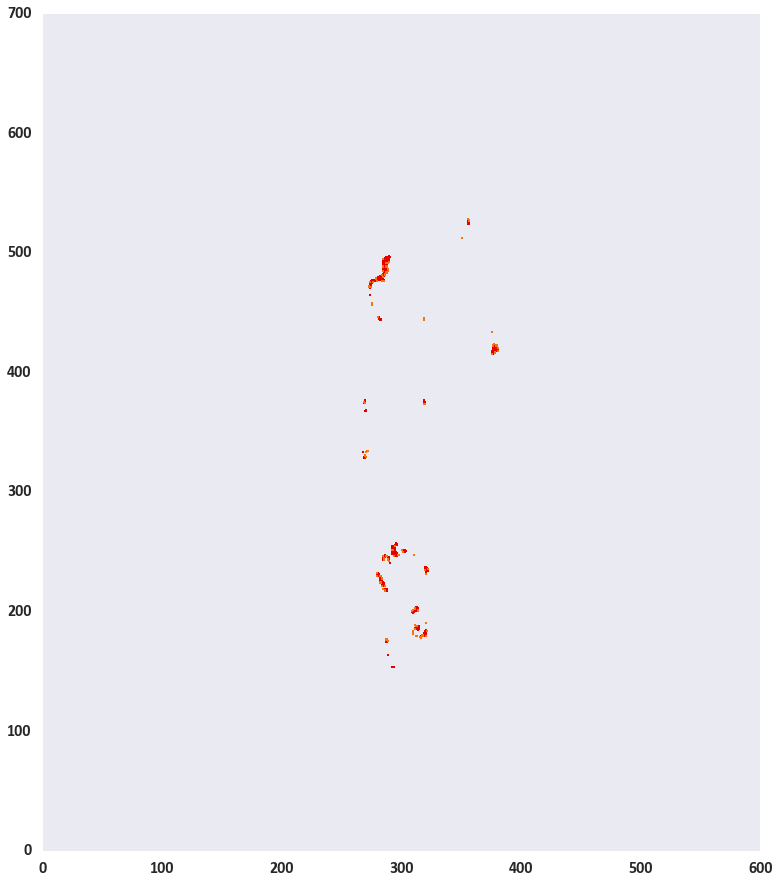

In [49]:
fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.set_aspect('equal')

ax1.pcolormesh(np.flipud(firecond1_masked), cmap=cmap1, vmin=0, vmax=1)
ax1.pcolormesh(np.flipud(firecondlow_masked), cmap=cmap3, vmin=0, vmax=1)